# Kinematics of Qronk

Qronk will have 12 degrees of freedom - 3 servo motors in each leg.

To move the robot we will need to use inverse kinematics, which will allow us to determine the angle of the servo motors based on our desired locations. This will have to be done for two components to allow freedom in control. 

1. Chassis: find the displacement and rotation of the chassis first, to adjust centre of gravity.
2. Feet: find the displacement of the feet, to move the robot forward.  

For development, we will begin by focusing on creating the inverse kinematics of one leg to move a foot. Chassis will need to be figured out afterwards. 


In [20]:
# Import libraries
import os

from math import cos, sin, pi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d


# Load URDF model
URDF_DIR = os.getcwd() + "/../qronk_description/urdf/"
xacro_model = URDF_DIR + "qronk.urdf.xacro"
urdf_model = !xacro {xacro_model}

## Forward-Kinematics

The forward kinematics is calculated based on the following diagram. Single leg kinematics will be done using the front-left leg of Qronk. Measurements are approximate, so re-measuring needs to be done on CAD. 

![joint_diagram](media/joint_diagram.png)

In [21]:
B = 0  # body to hip
L1 = 3.5  # hip to upper-leg
L2 = 10  # upper-leg to lower-leg
L3 = 10  # lower-leg to foot


def forwardKinematicsLeft(th1, th2, th3):
    # Body to hip
    T01_translation = np.array([[1, 0, 0, B], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T01_rotation = np.array(
        [
            [1, 0, 0, 0],
            [0, cos(th1), -sin(th1), 0],
            [0, sin(th1), cos(th1), 0],
            [0, 0, 0, 1],
        ]
    )
    T01 = T01_translation @ T01_rotation

    # Hip to upper-leg
    T12_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, L1], [0, 0, 1, 0], [0, 0, 0, 1]]
    )
    T12_rotation = np.array(
        [
            [cos(th2), 0, sin(th2), 0],
            [0, 1, 0, 0],
            [-sin(th2), 0, cos(th2), 0],
            [0, 0, 0, 1],
        ]
    )
    T12 = T12_translation @ T12_rotation

    # Upper-leg to lower-leg
    T23_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L2], [0, 0, 0, 1]]
    )
    T23_rotation = np.array(
        [
            [cos(th3), 0, sin(th3), 0],
            [0, 1, 0, 0],
            [-sin(th3), 0, cos(th3), 0],
            [0, 0, 0, 1],
        ]
    )
    T23 = T23_translation @ T23_rotation

    # Lower-leg to foot
    T3e = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L3], [0, 0, 0, 1]])

    # Combine matrices to get end-effector pose
    T01 = T01
    T02 = T01 @ T12
    T03 = T01 @ T12 @ T23
    T0e = T01 @ T12 @ T23 @ T3e

    # Get joint positions
    J1 = T01[0:3, 3]
    J2 = T02[0:3, 3]
    J3 = T03[0:3, 3]
    Je = T0e[0:3, 3]

    JointPos = [J1, J2, J3, Je]
    return JointPos


def forwardKinematicsRight(th1, th2, th3):
    # Body to hip
    T01_translation = np.array([[1, 0, 0, B], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T01_rotation = np.array(
        [
            [1, 0, 0, 0],
            [0, cos(th1), -sin(th1), 0],
            [0, sin(th1), cos(th1), 0],
            [0, 0, 0, 1],
        ]
    )
    T01 = T01_translation @ T01_rotation

    # Hip to upper-leg
    T12_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, -L1], [0, 0, 1, 0], [0, 0, 0, 1]]  # this is the only difference from Left
    )
    T12_rotation = np.array(
        [
            [cos(th2), 0, sin(th2), 0],
            [0, 1, 0, 0],
            [-sin(th2), 0, cos(th2), 0],
            [0, 0, 0, 1],
        ]
    )
    T12 = T12_translation @ T12_rotation

    # Upper-leg to lower-leg
    T23_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L2], [0, 0, 0, 1]]
    )
    T23_rotation = np.array(
        [
            [cos(th3), 0, sin(th3), 0],
            [0, 1, 0, 0],
            [-sin(th3), 0, cos(th3), 0],
            [0, 0, 0, 1],
        ]
    )
    T23 = T23_translation @ T23_rotation

    # Lower-leg to foot
    T3e = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L3], [0, 0, 0, 1]])

    # Combine matrices to get end-effector pose
    T01 = T01
    T02 = T01 @ T12
    T03 = T01 @ T12 @ T23
    T0e = T01 @ T12 @ T23 @ T3e

    # Get joint positions
    J1 = T01[0:3, 3]
    J2 = T02[0:3, 3]
    J3 = T03[0:3, 3]
    Je = T0e[0:3, 3]

    JointPos = [J1, J2, J3, Je]
    return JointPos

## Plotting the model

To visualise the calculations, the model will need to be plotted. This can either be done in a 3d plot, or a pair of 2d plots (front and side views). Pair of 2d plots seem to be more functional, but testing both of them out may be beneficial. 

Making a function to create the plot for given angles of joints will be required. Making a slider to adjust joint angles may be helpful for testing purposes but likely unnecessary. 


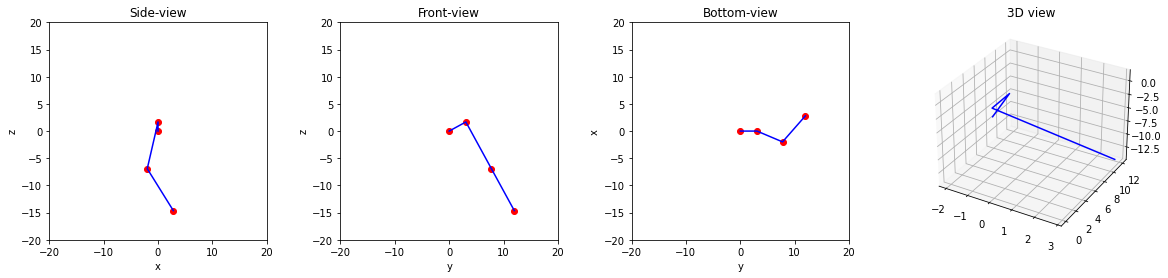

In [22]:
def plotLeg(JointPos):
    """Plots the leg in 3D space, given the joint positions in coordinates."""

    # unpack the joint positions
    x, y, z = zip(*JointPos)

    # create a figure
    plt.figure(figsize=(20, 4))

    # plot x-z plane (side-view)
    plt.subplot(141)
    plt.plot(x, z, "b-")
    plt.scatter(x, z, color="red")
    plt.title("Side-view")
    plt.xlabel("x")
    plt.ylabel("z")
    plt.axis("square")
    plt.axis([-20, 20, -20, 20])

    # plot y-z plane (front-view)
    plt.subplot(142)
    plt.plot(y, z, "b-")
    plt.scatter(y, z, color="red")
    plt.title("Front-view")
    plt.xlabel("y")
    plt.ylabel("z")
    plt.axis("square")
    plt.axis([-20, 20, -20, 20])

    # plot x-y plane (bottom-view)
    plt.subplot(143)
    plt.plot(y, x, "b-")
    plt.scatter(y, x, color="red")
    plt.title("Bottom-view")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.axis("square")
    plt.axis([-20, 20, -20, 20])

    # plot 3D view
    plt.subplot(144, projection="3d")
    plt.plot(x, y, z, "b-")
    plt.title("3D view")

    plt.show()


# Plot an example leg with arbitrary joint positions (for testing)
th1 = 0.5  # hip servo
th2 = 0.2  # upper-leg servo
th3 = -0.7  # lower-leg servoth1 = 0.5  # hip servo
plotLeg(forwardKinematicsLeft(th1, th2, th3))

## Calculating the inverse kinematics 

To calculate the inverse kinematics of the leg, basic trigonometry will be used. It will be easier to first perform this by hand and then implement it into this notebook. 

There also seems to be matrix methods available - if anyone finds more on this and find it applicable, we can discuss on using that instead to make the process faster. 

Some points to note before starting: 
- The angle of the joint connecting the hip and upper-leg will need to be determined first, as it provides the only out-of-plane movement.
- There will be two solutions (or more?) for each location, due to the fact that two of the links share the links share the same plane. 

![invkin_working](media/invkin_working.jpg)

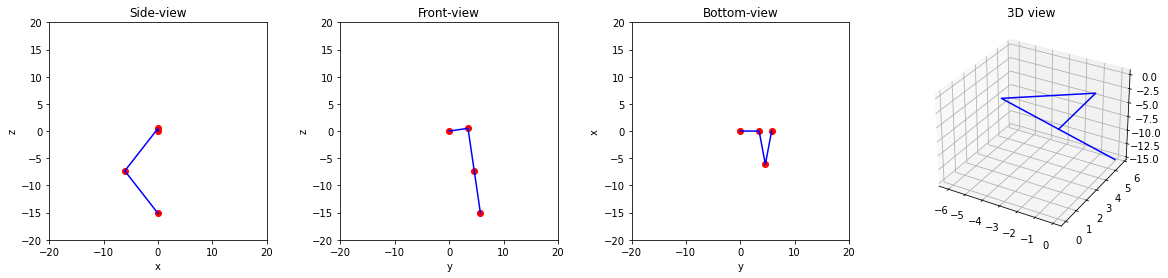

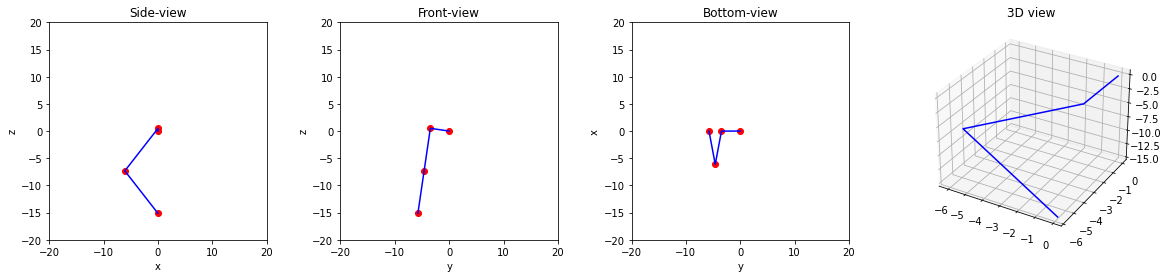

In [24]:
def inverseKinematicsLeft(Je):
    # Extract the x, y, z coordinates of the end effector position
    x, y, z = Je

    # Calculate shortest distances between joints
    d1e = np.sqrt(x**2 + y**2 + z**2)
    d2e = np.sqrt(d1e**2 - L1**2)

    # Calculate joint angles
    th1 = np.arccos(L1 / d1e) + np.arctan(z / y)
    th2 = np.arccos((L2**2 + d2e**2 - L3**2) / (2 * L2 * d2e))
    th3 = np.arccos((L2**2 + L3**2 - d2e**2) / (2 * L2 * L3)) - pi

    return th1, th2, th3


def inverseKinematicsRight(Je):
    # Extract the x, y, z coordinates of the end effector position
    x, y, z = Je

    # Calculate shortest distances between joints
    d1e = np.sqrt(x**2 + y**2 + z**2)
    d2e = np.sqrt(d1e**2 - L1**2)

    # Calculate joint angles
    th1 = -(np.arccos(L1 / d1e) - np.arctan(z / y))  # this is the only difference from Left
    th2 = np.arccos((L2**2 + d2e**2 - L3**2) / (2 * L2 * d2e))
    th3 = np.arccos((L2**2 + L3**2 - d2e**2) / (2 * L2 * L3)) - pi

    return th1, th2, th3


# Confirm that all left and right kinematics work correctly
th1, th2, th3 = inverseKinematicsLeft((2.3, 5.7, -15))
plotLeg(forwardKinematicsLeft(th1, th2, th3))

th1, th2, th3 = inverseKinematicsRight((2.3, -5.7, -15))
plotLeg(forwardKinematicsRight(th1, th2, th3))

## Making a gait sequence of semi-circle path

In [ ]:
def semi_circle_coordinates(n):
    if n <= 0:
        raise ValueError("Number of points must be greater than 0")

    # Calculate the angle between each point
    angle_increment = pi / (n - 1)

    # Generate coordinates using parametric equations
    coordinates_circ = [(1-cos(i * angle_increment), sin(i * angle_increment)) for i in range(n)]

    return coordinates

n =  20
coords = semi_circle_coordinates(n)
y_values, z_values = zip(*coords)

plt.figure(figsize=(6, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.title('Semi-Circle Gait')
plt.xlabel('Y-axis')
plt.ylabel('Z-axis')
plt.grid(True)
plt.axis('equal')  # Equal scaling for a proper circle appearance
plt.show()


th1(i), th2(i), th3(i) = inverseKinematicsLeft([0, y_values (i), z_values(i)]) for i in range(n)
plotLeg(forwardKinematicsLeft(th1, th2, th3))


(-5.5, 5.5, -15.248630473842068, -4.248630473842068)

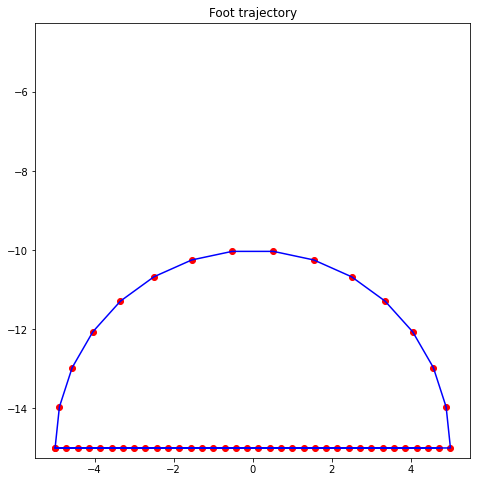

In [41]:
# Define gait parameters
radius = 5  # radius of the circle
period = 50  # number of frames per step
ground_fraction = 0.7  # percentage of period that foot is on the ground
origin = (0, 3.5, -15) # origin of the circle

# Define the trajectory of the foot, with semicircle loop path
def trajectory(t):
    ground_time = period * ground_fraction
    float_time = period * (1 - ground_fraction)
    if t < float_time:
        x = origin[0] + radius * cos(-pi * t / float_time)
        y = origin[1]
        z = origin[2] + radius * sin(pi * t / float_time)
    else:
        x = origin[0] + radius - 2 * radius * (t - float_time) / ground_time
        y = origin[1]
        z = origin[2]
    Je = (x, y, z)
    return Je

gait_sequence = [(-radius, 3.5, -15)]
for t in range(period):
    gait_sequence.append(trajectory(t))

# Plot the trajectory of the foot
x, y, z = zip(*gait_sequence)
plt.figure(figsize=(8, 8))
plt.plot(x, z, "b-")
plt.scatter(x, z, color="red")
plt.title("Foot trajectory")
plt.axis("square")

## Making animation for gait sequence

First, we will start with making the foot follow a semicircle path. Make a plot animation to show that the inverse kinematics works for this. 

Other projects seem to use a separate file system called .gait or something similar - should we consider doing something like this? We can first test using an array for just one leg, then decide whether such system will be necessary for gait sequences. 

## Determining the workspace

Calculating the workspace of the leg may be helpful for future calculations. This is the plot of all possible locations the foot can reach. To do so, joint angle limits will need to be determined (consider internal collisions and servo limits).  